In [16]:
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import proplot as pplt
from natsort import natsorted
import torch
from tqdm import tqdm
from twaidata.torchdatasets.DirectoryParser3DMRIDataset import *
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *

In [17]:
wmh_ds = WMHChallengeInterRaterDataset()

In [18]:
xs, ys, ind = wmh_ds[0]

In [19]:
ind

'Amsterdam_GE3T_100'

In [20]:
xs.keys()

dict_keys(['mask', 'FLAIR', 'T1'])

In [21]:
ys.keys()

dict_keys(['wmh', 'wmho3', 'wmho4'])

In [7]:
vol1 = []
vol2 = []
vol3 = []
dice = []
for (xs, ys, ind) in tqdm(wmh_ds):
        wmh1 = ys['wmho3'].cuda()
        wmh2 = ys['wmho4'].cuda()
        wmh3 = ys['wmh'].cuda()
        vol1.append(wmh1.sum().item())
        vol2.append(wmh2.sum().item())
        vol3.append(wmh3.sum().item())
        # dice.append((fast_dice(wmh1, wmh2) + fast_dice(wmh1, wmh3) + fast_dice(wmh2, wmh3)) / 3)
        dice.append(fast_dice(wmh1, wmh2))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.02it/s]


In [29]:
df = pd.DataFrame({
    "WMH1_ml":torch.Tensor(vol1) * 0.003,
    "WMH2_ml":torch.Tensor(vol2) * 0.003,
    "WMH3_ml":torch.Tensor(vol3) * 0.003,
    "DSC":torch.Tensor(dice)
})

In [30]:
def rater_volume_comparison(ax, x, y, fontsize):
    # Calculate line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept

    # Create scatter plot
    ax.scatter(x, y, color='deepskyblue', alpha=0.7, edgecolors='w', linewidth=0.5)

    # Plot line of best fit
    # 
    ax.plot([min(x), max(x)], [min(x), max(x)], color='gray', label=f'line y = x')
    # ax.plot(x, line, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')
    sns.regplot({'x':x, 'y':y}, x='x', y='y', ax=ax, scatter=False, ci=95, color='goldenrod', label=f'Best fit: y = {slope:.2f}x + {intercept:.2}')

    # Annotate with text (R^2 and line equation)
    ax.text(0.025, 0.90, f'$R^2 = {r_value**2:.3f}$', transform=plt.gca().transAxes,
             fontsize=fontsize-2,  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Enhance aesthetics
    ax.set_title('Rater 1 vs Rater 2 WMH Volume', fontsize=14, )
    ax.set_xlabel(r'Rater 1 WMH Volume (ml)', fontsize=fontsize, )
    ax.set_ylabel(r'Rater 2 WMH Volume (ml)', fontsize=fontsize, )
    ax.legend(fontsize=fontsize)


In [31]:
def dice_agreement_plot(ax, x, y, fontsize):
    ax.scatter(x, y, alpha=0.7, c='deepskyblue')

    # annotation
    ax.set_title("Dice agreement between raters", fontsize=fontsize+2)
    ax.set_xlabel(r"Mean WMH Volume (ml)", fontsize=fontsize)
    ax.set_ylabel("Dice between raters", fontsize=fontsize)
    
    # # point out influential outliers
    # xps = []
    # yps = []
    # for (xi, yi) in zip(x, y):
    #     if (xi > 10 and yi < 0.7) or (xi > 30 and yi < 0.8):
    #         xps.append(xi)
    #         yps.append(yi)
    # scatter = ax.scatter(xps, yps, facecolors='none', edgecolors='orange', linewidth=1, s=100, linestyle=':', label='Low Dice Outlier')
    # ax.legend()

In [32]:
def bland_altman_plot(ax, x, y, fontsize, title=True):
    mean = (x + y) / 2
    diff = (x - y)
    percent_diff = 100 * diff / np.minimum(x, y)
    mean_percent_diff = np.mean(percent_diff)

    std = np.std(percent_diff, ddof=1)
    conf_bound_95 = 1.96 * std
    
    ax.scatter(mean, percent_diff, color='goldenrod', alpha=0.7, edgecolors='w', linewidth=0.5)
    
    ax_text_colour = 'gray7'

    # mean and 95% confidence lines
    ax.axhline(y=mean_percent_diff, color='gray')
    rhs_point = max(x) * 0.79
    ax.text(rhs_point, mean_percent_diff + 1, 'mean diff:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - 3, f'{mean_percent_diff:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff - conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 + 1, '-1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 - 3, f'{mean_percent_diff - conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff + conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 + 1, '+1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 - 3, f'{mean_percent_diff + conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)

    # point out influential outliers
    outlier_sd = 3
    for (m, pd) in zip(mean, percent_diff):
        if pd > mean_percent_diff + (3 * std) or pd < mean_percent_diff - (3 * std):
            # the +0.1 and -0.1 are adjustments so that the dashes are centered on the dot from above
            scatter = ax.scatter(m+0.1, pd-0.1, facecolors='none', edgecolors=ax_text_colour, linewidth=1, s=100, linestyle=':')
            ax.text(m + max(x) * 0.035, pd - 2, 'Influential Outlier', verticalalignment='center', horizontalalignment='left', fontsize=fontsize, c=ax_text_colour)

    if title:
        ax.set_title("Bland Altman plot of Rater WMH Volumes", fontsize=fontsize+2)
    ax.set_ylabel("WMH Volume % Difference", fontsize=fontsize)
    ax.set_xlabel(r"Mean WMH Volume (ml)", fontsize=fontsize)

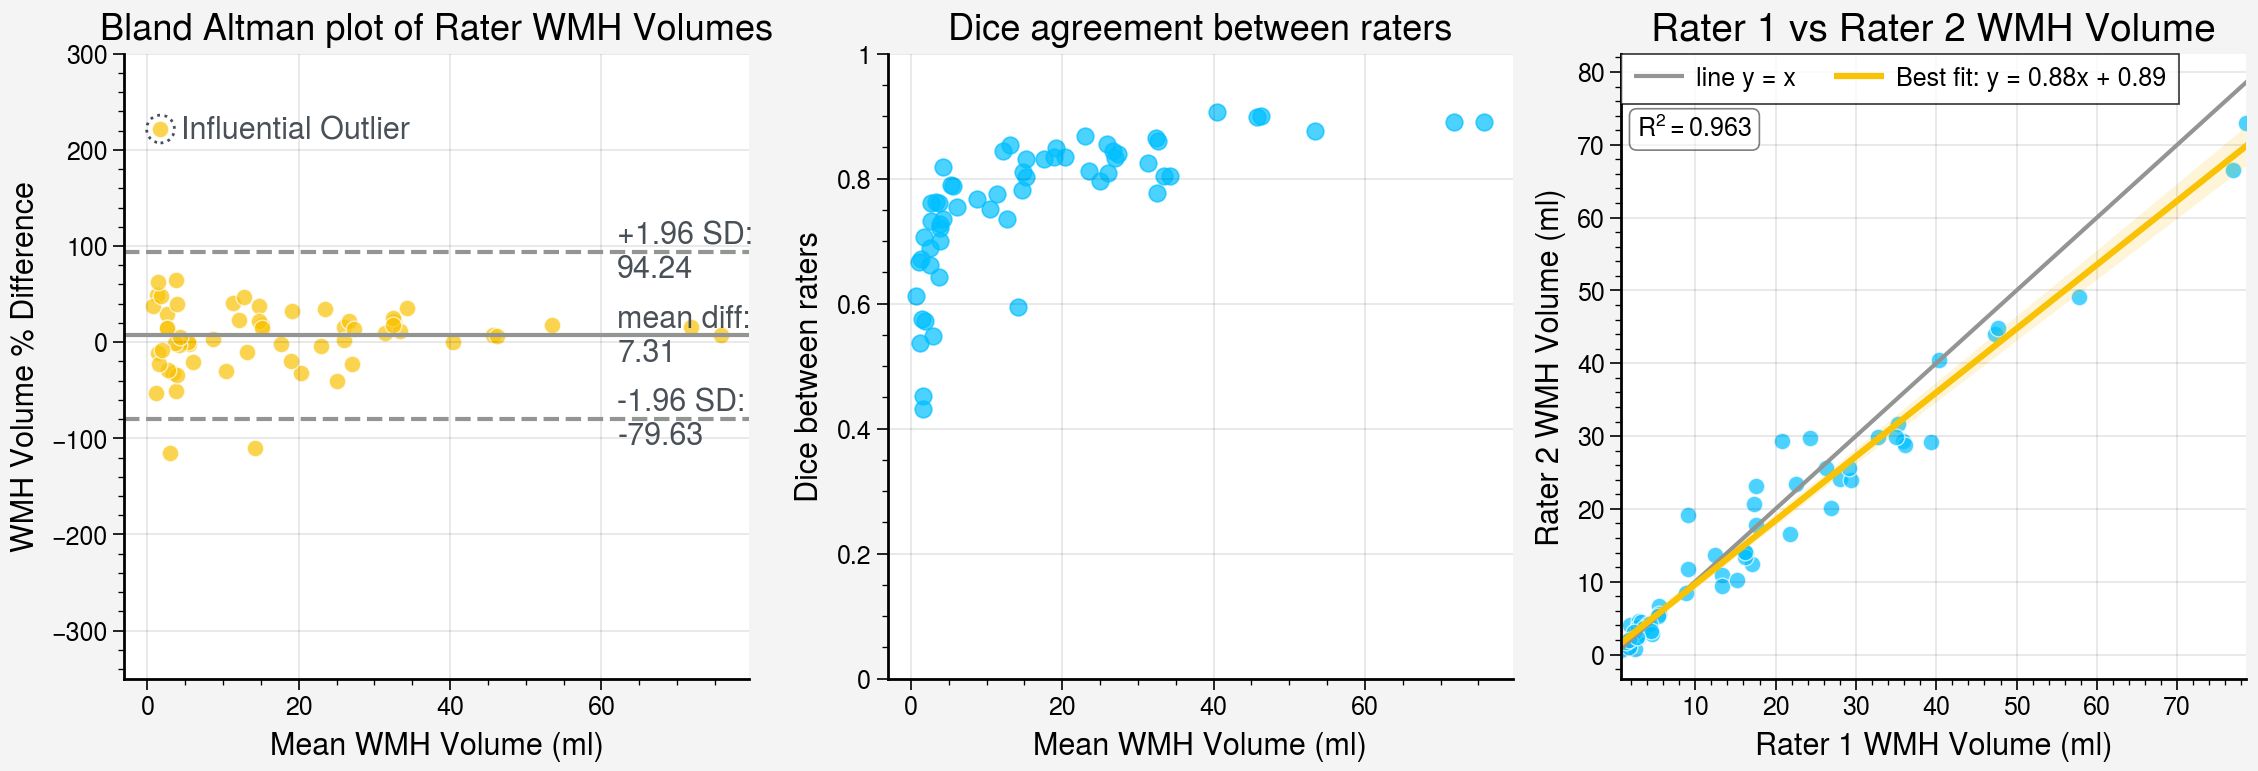

In [36]:
# spines and ticks
fig = pplt.figure(refwidth="25em", span=False, share=False)
axs = fig.subplots(nrows=1, ncols=3)

fontsize=11

x = df["WMH1_ml"]
y = df["WMH2_ml"]
bland_altman_plot(axs[0], x, y, fontsize)
axs[0].set_ylim((-350, 300))

y = df["DSC"]
x = (df["WMH1_ml"] + df["WMH2_ml"]) / 2
dice_agreement_plot(axs[1], x, y, fontsize)
axs[1].set_ylim((0, 1))

x = df["WMH1_ml"].values
y = df["WMH2_ml"].values
rater_volume_comparison(axs[2], x, y, fontsize)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.)
    ax.spines['bottom'].set_linewidth(1.)
    plt.minorticks_on()
    ax.tick_params(axis='both', labelsize=fontsize-2)
    
fig.save("combined overall metrics challenge.pdf")

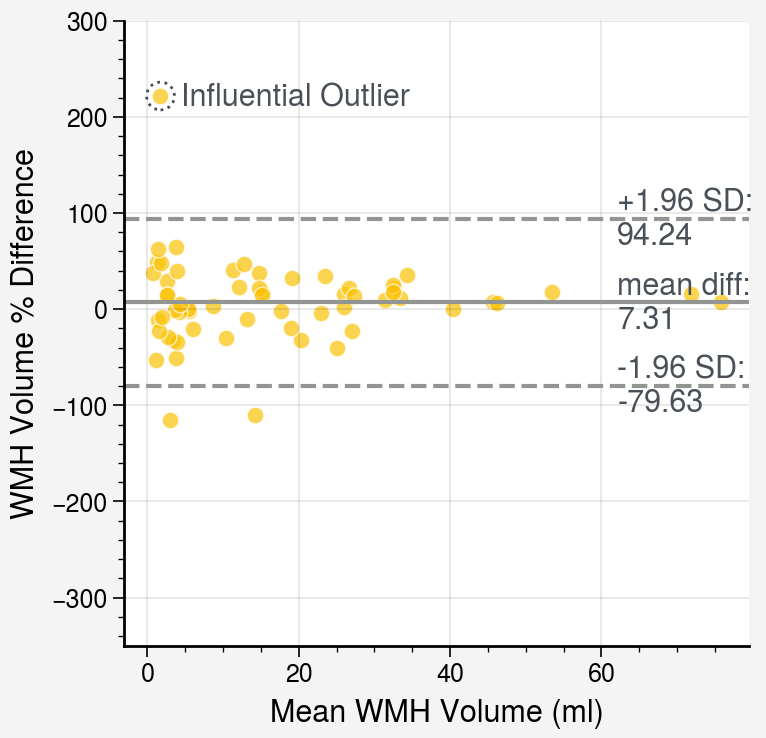

In [34]:
fig = pplt.figure(refwidth="25em", span=False, share=False)
axs = fig.subplots(nrows=1, ncols=1)

fontsize=11

x = df["WMH1_ml"]
y = df["WMH2_ml"]
bland_altman_plot(axs[0], x, y, fontsize, title=False)
axs[0].set_ylim((-350, 300))

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.)
    ax.spines['bottom'].set_linewidth(1.)
    plt.minorticks_on()
    ax.tick_params(axis='both', labelsize=fontsize-2)
    
fig.save("bland altman challenge.pdf")

In [35]:
ax.xaxis

### Todo: sort out the volumes across all the plots and data. Compare to the original challenge data paper that they had.

### Note to self, I need to think again and be careful about these bland altman plots and check whether I have implemented them correctly, secifically in the multi-rater case